# COLDER example: the 1D Ising chain

In this notebook we will review the simulation of the 1D Ising chain annealing using COLD optimization.

First, let us import the essential components that we will need to perform the simulation.

In [1]:
import colder.core.physics as cphys
import colder.models.lattice as cll
import colder.simulation.cold as ccold

import numpy as np

## Build the system hamiltonian and the AGP ansatz

Let us focus on the Hamiltonian of the reference paper ([Counterdiabatic Optimized Local Driving](https://link.aps.org/doi/10.1103/PRXQuantum.4.010312)).

$$\mathcal{H} = -J \sum_j^{N-1} \sigma_j^z \sigma_{j+1}^z + Z_0 \sum_j^N \sigma_j^z + \lambda(t)X_f \sum_j^N \sigma_j^x$$

Looking at the papers, we first have to define some functions and constants that regulate the annealing schedule. In the following, `scale_f` represents $\lambda(t)$, `f_qoc` the control function $f(t, \beta)$ (as of Eq. 17). $\tau$ represents the total annealing time.

In [2]:
def scale_f(t, tau):
    """Define the scaling function [0,tau] -> [0,1]."""
    return np.sin( (np.pi/2)*(np.sin(np.pi*t/(2*tau))**2)  )**2

def f_qoc(t : float, tau : float, beta : np.ndarray):
    """control function f(t, beta) to use for qoc"""
    #beta = np.array([beta])
    k = np.arange(len(beta)) + 1
    
    if isinstance(t, np.ndarray):
        # fix the sum broadcast when time is an array
        t = t.reshape(-1, 1)
        return np.sum( beta*np.sin( np.pi*k*t/tau ), axis=1 )
    else:
        return np.sum( beta*np.sin( np.pi*k*t/tau ) )

In the next step, we define the functions that *drive* our system, namely $J(t)$, $Z(t)$ and $X(t)$, one for each term that composes the hamiltonian $\mathcal{H}$.
This is done using python functions that take some inputs, the first of which *must be* the time value $t$, and that returns the desired coefficient.

We will use 5 spins, for simplicity.

In [3]:
# parameters of the system
Jsys = 1.0
Z0sys = 0.02*Jsys
Xfsys = 10*Jsys

# we use the lattice module to prompt easily the spin indices
lattice = cll.chain(nspin = 5)
nspin = lattice.nspin

# number of frequencies of the control function (will be used later)
Nk = 1

In [4]:
# note: these functions should have same I/O
def Jf(t, tau, beta):
    return -Jsys*np.ones_like(t)
    #            ^^^ trick to avoid issues in vectorialization

def xf(t, tau, beta):
    return Xfsys*scale_f(t, tau)
def zf(t, tau, beta):
    return Z0sys*np.ones_like(t) + f_qoc(t, tau, beta)

H_J = cphys.hamiltonian('ZZ', lattice.nearest_neighbor, coeff = 'J', coeff_function=Jf)
H_Z = cphys.hamiltonian('Z', lattice.single_site, coeff = 'Z', coeff_function=zf)
H_X = cphys.hamiltonian('X', lattice.single_site, coeff = 'X', coeff_function=xf)

H = H_J + H_Z + H_X
H.expression()

J*Sum(sigma_ZZ**i, (i, 1, 4)) + X*Sum(sigma_X**i, (i, 1, 5)) + Z*Sum(sigma_Z**i, (i, 1, 5))

**Note**: In this case $J(t)$ is just a constant. To avoid errors in the vectorialization, I suggest to use `np.ones_like(t)` to be vector-safe.

**Important**: All the functions must have the same I/O, i.e. the same input parameters. In this specific case, all the coefficient functions `Jf`, `xf` and `zf` receive the inputs `(t, tau, beta)`, even though not all of them use all the input parameters.

### AGP ansatz

It is time to prompt the APG ansatz. We will use the second order LCD potential, as of Eq. 26:
$$\mathcal{A}^{(2)} = \alpha \sum_i^N \sigma_i^y + \gamma\sum_i^{N-1} ( \sigma_i^x\sigma_{i+1}^y + \sigma_i^y\sigma_{i+1}^x ) + \zeta\sum_i^{N-1} ( \sigma_i^z\sigma_{i+1}^y + \sigma_i^y\sigma_{i+1}^z )$$

Again, the interface for this is the `physics.hamiltonian` module:

In [5]:
ansatz_alpha = cphys.hamiltonian('Y', lattice.single_site, 'alpha')
ansatz_gamma = cphys.hamiltonian('XY', lattice.add_invert(lattice.nearest_neighbor), 'gamma')
ansatz_zeta = cphys.hamiltonian('ZY', lattice.add_invert(lattice.nearest_neighbor), 'zeta')

ansatz = cphys.hamiltonian_collection(ansatz_alpha, ansatz_gamma, ansatz_zeta)
ansatz.expression()

alpha*Sum(sigma_Y**i, (i, 1, 5)) + gamma*Sum(sigma_XY**i, (i, 1, 8)) + zeta*Sum(sigma_ZY**i, (i, 1, 8))

### Explaination of `add_invert` shortcut

Let us break down the usage of `lattice.add_invert()`. The `nearest_neighbor` item will return the nearest neighbor interactions
```python
    >>> lattice.nearest_neighbor
    [(0, 1), (1, 2), (2, 3), (3, 4)]
```

thus, the code
```python
    cphys.hamiltonian('XY', lattice.nearest_neighbor, 'gamma')
```

would build the term $\sum_i^{N-1} \sigma_i^x\sigma_{i+1}^y$ of $\mathcal{A}$.
Now one can notice that the following term features interactions in which Y and X are inverted ($\sigma_i^y\sigma_{i+1}^x$), therefore we can as well invert each tuple of the spin targets to achieve the same result. Indeed, the method `lattice.add_invert(tl)` inverts the input tuple list `tl` and returns both the original list and the list of inverted tuples.
```python
    >>> lattice.add_invert(lattice.nearest_neighbor)
    [(0, 1), (1, 2), (2, 3), (3, 4), (1, 0), (2, 1), (3, 2), (4, 3)]
```

<br><br>

## create the COLDER simulation

In [6]:
tau : float = 0.01   # total annealing time
nsteps : int = 200   # number of discrete steps to perform in the annealing simulation
backend = 'scipy'

csym = ccold.cold(
    system = H, ansatz = ansatz, annealing_time = tau, nspin = nspin,
    # parameters to be passed at the system coefficient functions
    system_fargs = {'tau' : tau, 'beta' : np.zeros(Nk)}, 
    # name of the parameter to treat as QOC parameter (which will be tweaked during the optimization)
    qoc_parameters=['beta'],
    # backend
    backend = backend
)

[info] caching agp


<br>

### let us take a look at the gauge potential!

The `agp` attribute of the colder simulation contains the object that computes and solves the Adiabatic Gauge Potential symbolically.

In [7]:
csym.agp.compute_square_trace()

48.0*J**2*gamma**2 + 48.0*J**2*zeta**2 + 64.0*Z**2*gamma**2 + 20.0*(-X*alpha - 0.5*dZ)**2 + 64.0*(-X*zeta - 0.25*dJ)**2 + 64.0*(X*zeta - Z*gamma)**2 + 32.0*(J*alpha - X*gamma + Z*zeta)**2 + 48.0*(J*zeta + 0.5*Z*alpha - 0.25*dX)**2 + 8.0*(J*zeta + Z*alpha - 0.5*dX)**2

Here you are! Now you have the AGP without making the math yourself. The computation is instantaneous for small systems, but scales polynomially for bigger systems. However, this is all you need to test an arbitrary AGP on the flight, as the AGP working on smaller systems will work also on bigger ones.

## initialize the simulation

The following command is crucial to initialize all the requirements before using the COLD object for simulations.
This method computes the AGP and optimizes numerically the interpolation of the schedule functions.

In [8]:
csym.be_ready()

If you like, you can plot the schedule functions...

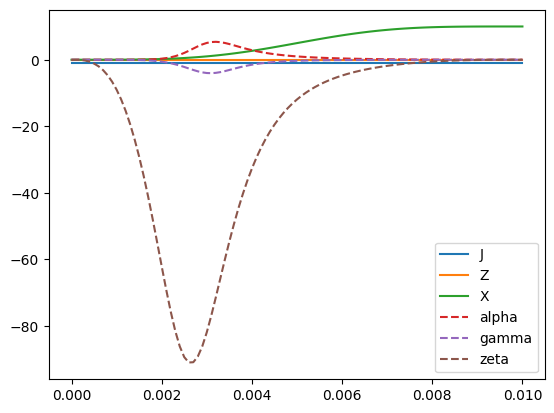

In [9]:
# check the schedules
csym.plot_schedules()

... or the spectrum of the system hamiltonian.

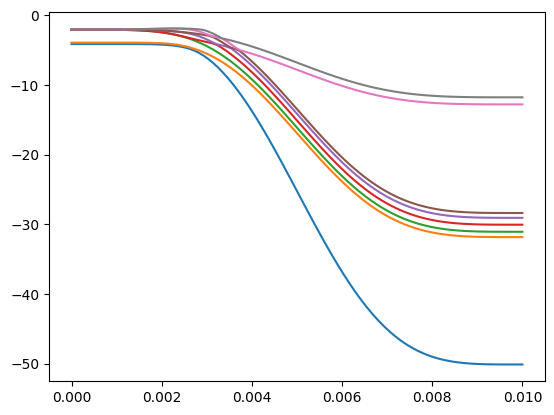

In [10]:
csym.plot_spectrum(use_H0=True)

If you want to access to the hamiltonian as function of time, use the following:

In [11]:
H_t = csym.make_timedependent_hamiltonian()

H_t(0.0) # let's print it

array([[-3.9 +0.j        ,  0.  +0.08371406j,  0.  +0.16748091j, ...,
         0.  +0.j        ,  0.  +0.j        ,  0.  +0.j        ],
       [ 0.  -0.08371406j, -1.94+0.j        ,  0.  +0.j        , ...,
         0.  +0.j        ,  0.  +0.j        ,  0.  +0.j        ],
       [ 0.  -0.16748091j,  0.  +0.j        ,  0.06+0.j        , ...,
         0.  +0.j        ,  0.  +0.j        ,  0.  +0.j        ],
       ...,
       [ 0.  +0.j        ,  0.  +0.j        ,  0.  +0.j        , ...,
        -0.06+0.j        ,  0.  +0.j        ,  0.  -0.16758649j],
       [ 0.  +0.j        ,  0.  +0.j        ,  0.  +0.j        , ...,
         0.  +0.j        , -2.06+0.j        ,  0.  -0.08381964j],
       [ 0.  +0.j        ,  0.  +0.j        ,  0.  +0.j        , ...,
         0.  +0.16758649j,  0.  +0.08381964j, -4.1 +0.j        ]])

## Annealing simulation

Before using the optimization of the schedule provided by the colder package, let us test the performances of annealing schedules for the Ising model **without any optimization**.

In [12]:
import colder.simulation.annealing
import colder.quantum.math

The `annealing` module provides the tools to simulate any time evolution given an hamiltonian which is function of time.

In [13]:
ann = colder.simulation.annealing.annealing(tau, P = nsteps, backend = backend)

Also, we need the initial state of the time evolution and the final groundstate to evaluate the fidelity.

In this work, we get the initial state as the ground state of the system hamiltonian at time zero.

In [14]:
# computing initial state and true ground state
psi0 = csym.get_psi_zero()
truegs = csym.get_psi_final()

### standard annealing schedule

What happens if one simulates the annealing without any form of optimization? In order to do so, we can get the timedependent hamiltonian without any gauge potential using the method 
```python
    H0 = csym.make_timedependent_hamiltonian_nogauge()
```

In [15]:
H0 = csym.make_timedependent_hamiltonian_nogauge()
psi_bare = ann.run(H0, psi0=psi0)

The method `run` of the annealing object will run the time evolution as specified in the construction of the annealing object itself. The initial state of the evolution is prompted through the `psi0` argument. The method returns the final evolved state, which we can finally use to compute the fidelity wrt the true ground state of $\mathcal{H}$ at time $\tau$.

In [16]:
colder.quantum.math.fidelity(psi_bare, truegs)

0.03855172461180932

As you can see, the fidelity is not optimal.

### LCD annealing

What happens if we use Local Counterdiabatic Driving? We can test this running another simulation using the hamiltonian which includes the AGP terms. We have already computed it in `H_t`.

In [17]:
psi = ann.run(H_t, psi0=psi0)
colder.quantum.math.fidelity(psi, truegs)

0.21910167164306396

Indeed, the fidelity improves. But can we do better?

## COLD optimization

In this section we will run a COLD optimization. The first step is to **define a loss function**.
By default, the loss function must take as input two arguments:
- the final evolved state `psi`
- the QOC parameters `param` (in this case it is the $\beta$ of QOC function)

In [18]:
def loss_infidelity(psi, param):
    infidelity = 1 - colder.quantum.math.fidelity(psi, truegs)
    print( f'beta = {param}, infidelity = {infidelity}') #add this just to print the progress
    return infidelity

The optimization can be achieved using the suggested Powell method through the `run_cold_opti()` method.

In [19]:
x0 = np.random.uniform(size=Nk) # initial guess of parameters

optim = csym.run_cold_opti(init_parameters = x0,
    loss_function = loss_infidelity, psi0 = psi0, annealer_nsteps=nsteps, 
    options={'disp': True} # options for the scipy.optimizer function
)

beta = [0.94499884], infidelity = 0.11119912677783805
beta = [0.94499884], infidelity = 0.11119912677783805
beta = [1.94499884], infidelity = 0.03895332700879728
beta = [3.56303284], infidelity = 0.0034577432633339233
beta = [3.32482657], infidelity = 0.004993275223888927
beta = [6.18106687], infidelity = 0.00020971002698566554
beta = [4.99901195], infidelity = 0.0005463580679356816
beta = [10.41713493], infidelity = 0.00011270341733615741
beta = [8.36354825], infidelity = 0.00010861290542785174
beta = [7.52991457], infidelity = 0.00012272044717931418
beta = [9.14794854], infidelity = 0.00010584888082743049
beta = [8.96850481], infidelity = 0.00010586822988156719
beta = [9.22997804], infidelity = 0.00010593985763018843
beta = [9.06591904], infidelity = 0.000105819284546671
beta = [17.18683925], infidelity = 0.00024858181345366326
beta = [9.06591904], infidelity = 0.000105819284546671
beta = [17.18683925], infidelity = 0.00024858181345366326
beta = [-4.07400595], infidelity = 0.99999999

After the convergence of the optimizer, the simulation object is updated with the optimal parameters by default. We clearly see that the fidelity is improved by orders of magnitude, in this example.

In [20]:
optim_beta = optim.x
optim_f = optim.fun
print('minimum loss value {} with beta = {}'.format(optim_f, optim_beta))
print('fidelity =', 1-optim_f)

minimum loss value 0.00010581924957131505 with beta = [9.06862577]
fidelity = 0.9998941807504287


<br><br>

### Run manually the optimization using any other tool

The *colder* package allows to fetch the function to be optimized and run the optimization using any other tool. 
In this section we will fetch the optimization function and run inference-based methods to optimize it.

In [21]:
f0_min = csym.make_cold_optimization_function(loss_function = loss_infidelity, psi0 = psi0, annealer_nsteps=nsteps)

As a first example, we use **Gaussian minimization** from skopt. 

Ref: https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html

In [22]:
from skopt import gp_minimize

skres = gp_minimize(f0_min,           # the function to minimize
                  [(-10.0, 10.0)],    # bounds on each dimension of x
                  acq_func="EI",      # acquisition function
                  n_calls=15,         # number of evaluations of f
                  n_random_starts=5,  # number of random initialization points
                  random_state=1234   # random seed
)

beta = [-0.04672667054701307], infidelity = 0.8229494216018249
beta = [6.356768822331393], infidelity = 0.00018972820224072429
beta = [2.2422378935454184], infidelity = 0.026648192864348497
beta = [5.427198377248024], infidelity = 0.00036405017849427956
beta = [7.213395427553749], infidelity = 0.0001332139248541031
beta = [3.4718773539291377], infidelity = 0.003973977638242365
beta = [-10.0], infidelity = 0.9999999999962738
beta = [10.0], infidelity = 0.00010932109388406275
beta = [8.839526027316534], infidelity = 0.00010608295523817368
beta = [2.8646982460803123], infidelity = 0.010380964211278099
beta = [4.514514514759366], infidelity = 0.0009391913870580026
beta = [8.065330742783164], infidelity = 0.00011193835583500622
beta = [9.514293592793056], infidelity = 0.00010669097404480965
beta = [-6.308661586303132], infidelity = 0.9999999999943713
beta = [4.022286435017344], infidelity = 0.0017763121942927507


In [23]:
print('infidelity {} with beta = {}'.format(skres.fun, skres.x))

infidelity 0.00010608295523817368 with beta = [8.839526027316534]


As last example, we use the **bayes_opt** package.

Ref: https://github.com/bayesian-optimization/BayesianOptimization

In [24]:
from bayes_opt import BayesianOptimization


# this module likes to maximize functions, so we change the loss function!
def loss_fidelity(psi, param):
    return colder.quantum.math.fidelity(psi, truegs)

f0_max = csym.make_cold_optimization_function(loss_function = loss_fidelity, psi0 = psi0, annealer_nsteps=nsteps)


optimizer = BayesianOptimization(
    f = lambda x: f0_max(np.array([x])), # fix: this module does not input parameters as numpy array, so we force it...
    pbounds = {'x': (-10, 10)},
    random_state = 1, allow_duplicate_points=True
)

optimizer.maximize(
    init_points=3,
)

|   iter    |  target   |     x     |
-------------------------------------
| 1         | 2.004e-05 | -1.66     |
| 2         | 0.9989    | 4.406     |


| 3         | 3.726e-12 | -9.998    |
| 4         | 0.9991    | 4.566     |
| 5         | 0.9999    | 10.0      |
| 6         | 0.9999    | 7.869     |
| 7         | 0.9999    | 9.01      |
| 8         | 0.9998    | 6.384     |
| 9         | 0.9999    | 7.096     |
| 10        | 0.9997    | 5.535     |
| 11        | 0.9999    | 9.569     |
| 12        | 0.9999    | 8.428     |
| 13        | 0.9998    | 5.96      |
| 14        | 0.9995    | 5.031     |
| 15        | 0.9999    | 7.482     |
| 16        | 0.9998    | 6.747     |
| 17        | 0.9999    | 8.718     |
| 18        | 0.9999    | 9.283     |
| 19        | 0.9999    | 8.147     |
| 20        | 0.9999    | 9.774     |
| 21        | 0.9999    | 9.996     |
| 22        | 0.9999    | 7.666     |
| 23        | 0.9999    | 7.265     |
| 24        | 0.9998    | 6.197     |
| 25        | 0.9999    | 8.838     |
| 26        | 0.9999    | 6.872     |
| 27        | 0.9999    | 9.345     |
| 28        | 0.9999    | 8.34      |


In [25]:
print('infidelity {} with beta = {}'.format(1-optimizer.max['target'], optimizer.max['params']))

infidelity 0.00010583602466351927 with beta = {'x': 9.009775723653998}
